# 1. 문제정의
- 타이타닉 탑승자의 정보를 토대로 생존과 사망 예측해보기

# 2. 데이터 수집
- Kaggle에서 train, test, gender_submission 다운로드

In [81]:
import pandas as pd
train = pd.read_csv('./data/titanic/train.csv')
test = pd.read_csv('./data/titanic/test.csv')
train.shape, test.shape
# train : 891,12 = 문제데이터(11) + 정답 데이터 (1)
# test : 418,11 = 문제데이터(11)
# test데이터의 정답을 예측 해보는것 = train 데이터로 학습해서 알아내어야함
# 첫날 엑셀 분석으로 1등 : 0.78XXX
# 성별 + 하나의 기준

# 891 개의 데이터를 통해서 생존과 사망과련한 규칙을 머신러닝 모델로 찾고
# 418개 데이터의 생존과 사망을 예측하자

((891, 12), (418, 11))

# 3. 데이터 전처리

In [83]:
# 결측치 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [84]:
test.info()
#  결측치가 있는 컬럼
# train - Age, Cabin, Embarked
# test - Age, Fare, Cabin

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [85]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Passengerld
- 삭제
- 생존/사망에 연관성이 없다

In [87]:
# inplace= True
train.drop('PassengerId',axis =1, inplace= True )

In [88]:
test.drop('PassengerId',axis =1, inplace= True )

## Survived
- 정답컬럼
- 분석시에 기준으로 사용

In [90]:
y_train = train['Survived']

## Embarked
- 탑승한 항구 데이터 (사우스햄튼 S, 쉘부르크 C, 퀸즈타운 Q)
- train 데이터에 결측치 2개
- 최빈값으로 채우기 > 결측치가 많지 않을때

In [92]:
# S 가 889개 중에서 644개 존재 = 72.4% 확율로 S 일 것이다.
# 둘 다 S 일 확률은 72.4%*72.4% = 52.4%
train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [93]:
# 분홍창 = 경고
# 너 조금 틀렸는데 파이썬이 고쳐줄게..!

train['Embarked'].fillna('S',inplace=True)

C:\Users\smhrd\AppData\Local\Temp\ipykernel_8048\473392351.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Embarked'].fillna('S',inplace=True)


In [94]:
# copy() : 값을 가져와서 새로운 주소로 활당
X = train.copy()

In [95]:
id(X)

2461266421248

## Fare(요금)
- test 1개의 결측치 존재
- 중앙값, 평균값
- 중앙값으로 채움
- 평균값은 이상치가 있을때 이상치에 영향을 많이 받음
- 중앙값은 이상치가 있을때 이상이에 영향을 적게 받음

In [97]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


In [98]:
test['Fare'].describe()

count    417.000000
mean      35.627188
std       55.907576
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64

In [99]:
test['Fare'].fillna(14.45, inplace= True)

C:\Users\smhrd\AppData\Local\Temp\ipykernel_8048\1973921421.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Fare'].fillna(14.45, inplace= True)


In [118]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      418 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


## Age
- train에 약 200개, test에 약 100개의 결측치 존재
- 결측치가 많아서 최빈값, 중앙값을 사용하기 애매함
- 가지고 있는 데이터 중에서 나이와 연관성이 많은 데이터 활용
- 객실등급, 성별데이터를 활용해서 나이 결측치 채우기

In [121]:
# 상관관계
# 피어슨 상관계수
# -1~ 1 까지로 두변수의 상관관계를 표현
# - : 음의 상관관계(반비례)
# + : 양의 상관관계(비례)
# 1 ~ 0.7 : 강한 양의 상관관계
# 0.7 ~ 0.3 : 약한 양의 상관관계
# 0.3 ~ 0 : 약한 양의 상관관계
# 절댓값이 1에 가까울수록 연관성이 크다
# 절댓값이 0에 가까울수록 연관성이 작다
train.corr(numeric_only=True)

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [131]:
age_table=train[['Pclass','Age','Sex']].groupby(by = ['Pclass','Sex']).median()

In [129]:
# Age의 값을 확인해보고 결측치가 아니면 그대로 사용
# 결측치라면 객실등급과 성별을 확인 후 결측치 채우기
# 전체 데이터에 반복
train.iloc[5]

Survived                   0
Pclass                     3
Name        Moran, Mr. James
Sex                     male
Age                      NaN
SibSp                      0
Parch                      0
Ticket                330877
Fare                  8.4583
Cabin                    NaN
Embarked                   Q
Name: 5, dtype: object

In [ ]:
# apply 함수를 활용해서 커스텀 함수를 전체 데이터에 적용하기
# apply : 행이나 열 단위로 복잡한 작업(ㅋ커스텀 함수)을 할 때 사용
# apply 함수는 행이나 열 단위로 한 줄의 데이터씩 커스텀 함수를 적용시킴
# 필요한 것 : 커스텀 함수 , 적용할 데이터

In [143]:
import numpy as np
def fill_age(person):
    if np.isnan(person['Age']):
        return age_table.loc[person['Pclass'],person['Sex']][0]
    else :
        return person['Age']

In [145]:
train['Age']=train.apply(fill_age, axis = 1)
test['Age']=train.apply(fill_age, axis = 1)

C:\Users\smhrd\AppData\Local\Temp\ipykernel_8048\918205116.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return age_table.loc[person['Pclass'],person['Sex']][0]


In [147]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


# Cabin
- 객실 구역 A ~ G 정도의 구역 안에서 객실의 번호도 적혀있음
- 약 700개의 결측치가 존재 > 결측치를 하나의 데이터로 사용
- 200개 데이터중 중복제거 후 148개  데이터
- 데이터의 갯수가 너무 많은채로 학습시키면 규칙이 너무 복잡하게 설계 > 과대적합
- 데이터를 그룹화해서 종류를 줄여야 한다 > 일반화를 시켜야 함

In [152]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [157]:
# 같은 구역끼리 하나의 데이터로 그룹화
train['Cabin'] = train['Cabin'].str[0]
test['Cabin'] = test['Cabin'].str[0]

In [163]:
import warnings
warnings.filterwarnings('ignore')

In [165]:
# 결측치를 하나의 데이터로 사용 > 결측치인 데이터들은 비슷한 특징이 있을거라 가정
train['Cabin'].fillna('N',inplace=True)
test['Cabin'].fillna('N',inplace=True)

## Name
- 생존과 사망과의 연관성을 찾아야함
- 중간에 위치한 호칭을 가져와서 사용

In [179]:
train['Name'][1].split(',')[1].split('.')[0].strip()

'Mrs'

In [181]:
def split_title(name):
    return name.split(',')[1].split('.')[0].strip()

In [183]:
train['Name'] = train['Name'].apply(split_title)
test['Name'] = test['Name'].apply(split_title)


In [189]:
train['Name'].value_counts()
# 데이터의 갯수가 적은것들은 과대적함을 유발

Name
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [191]:
convert_title_dic = {
    'Mr' : 'Mr' , 
    'Mrs' : 'Mrs', 
    'Miss' : 'Miss', 
    'Master' : 'Master', 
    'Don' : 'Other', 
    'Rev' : 'Rev', 
    'Dr': 'Dr', 
    'Mme' : 'Other', 
    'Ms' : 'Other',
    'Major' : 'Other',
    'Lady' : 'Other',
    'Sir' : 'Other',
    'Mlle' : 'Other',
    'Col' : 'Other', 
    'Capt' : 'Other', 
    'the Countess' : 'Other',
    'Jonkheer' : 'Other',
    'Dona' : 'Other'
}

In [193]:
train['Name'] = train['Name'].map(convert_title_dic)
test['Name'] = test['Name'].map(convert_title_dic)

In [195]:
train['Name'].value_counts()

Name
Mr        517
Miss      182
Mrs       125
Master     40
Other      14
Dr          7
Rev         6
Name: count, dtype: int64

## Ticket
- 티켓의 고유 번호
- 생존/사망과 연관성 찾기가 힘듬 > 삭제해버렷

In [205]:
# train['Ticket'].unique()
train.drop('Ticket',axis=1,inplace=True)
test.drop('Ticket',axis=1,inplace=True)

## SibSp, Parch
- 동승한 가족
- 따로 처리할게X

In [212]:
train['Parch'].value_counts()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

# 4. 탐색적 데이터 분석
- 그래프를 그리면서 데이터 자세히 보기
- 데이터 전처리 하면서 변경된 데이터

In [216]:
# matplotlib : 자세하게 적어야함
# 장점 : 세부적인 값을 수정할 수 있음
# 단점 : 코드가 길다
import seaborn as sns 
# seaborn : 그래프 쉽게 그리기
#장점 : 코드가 짧다
#단점 : 세부적인 값을 수정할 수 없음

## Cabin
- 700개의 결측치를 임의로 채웠다 > 의미가 있나 확인하기

<Axes: xlabel='Cabin', ylabel='count'>

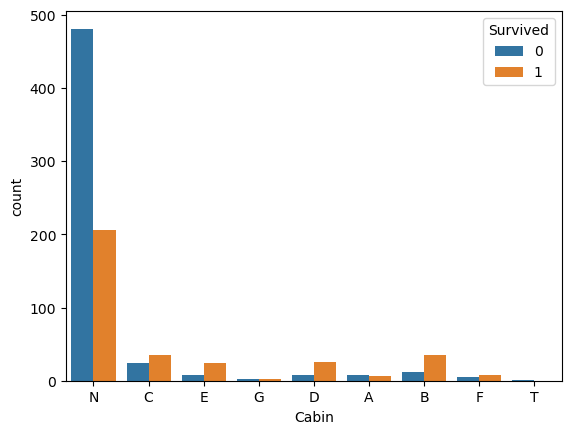

In [223]:
# Cabin의 데이터의 갯수를 세어주는데, Survived 값을 기준으로 센다
# 임의로 채운 N은 다른데이터와 비교했을때 크게 이상하진 않다 = 사용하자
sns.countplot(data = train, x= 'Cabin', hue ='Survived')

## Pclass
- 객실의 등급별로 생존/사망과 연관성이 있는

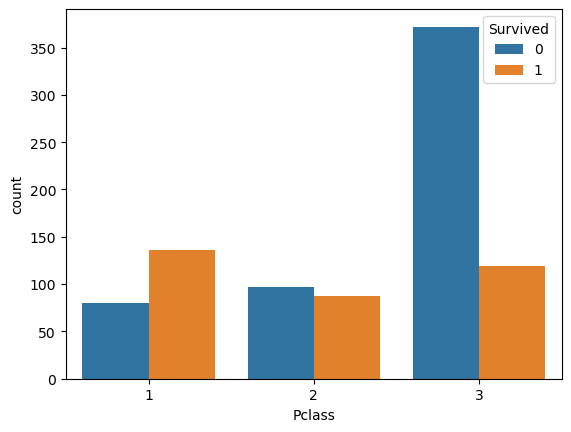

In [237]:
sns.countplot(data=train, x='Pclass',hue='Survived');

## Embarked
- 탑승한 항구가 생존/사망과 어떤 연관성이 있는가?

<Axes: xlabel='Embarked', ylabel='count'>

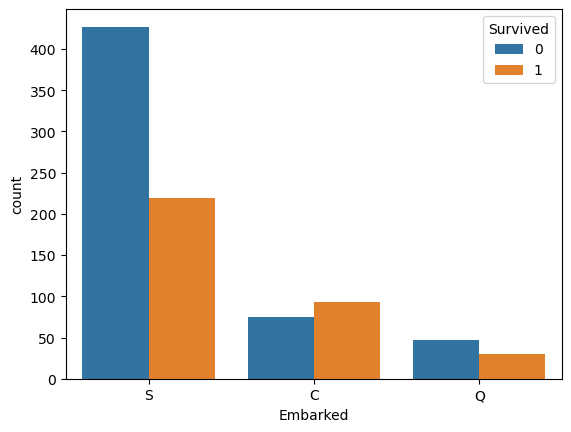

In [239]:
sns.countplot(data=train, x='Embarked',hue='Survived')

# 데이터 타입 변경
- 원핫인코딩 하기 전에 데이터를 합쳐줘야함
- 합쳐지지 않으면 train 과 test의 데이터가 달라질 수도 있다

In [250]:
train['Parch'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [254]:
test['Parch'].unique()

array([0, 1, 3, 2, 4, 6, 5, 9], dtype=int64)

In [258]:
train.drop('Survived', axis=1, inplace = True)

In [260]:
# 데이터 합치고 원핫인코딩 후 분리하기
combined = pd.concat([train,test],ignore_index=True)

In [263]:
X_onehot = pd.get_dummies(combined)

# 5. 모델 선택 및 하이퍼 파라미터 튜닝

In [265]:
# 데이터 나누기
X_train = X_onehot.iloc[:891]
X_test = X_onehot.iloc[891:]

In [267]:
X_train.shape, X_test.shape, y_train.shape

((891, 26), (418, 26), (891,))

In [269]:
X_train.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Name_Dr', 'Name_Master',
       'Name_Miss', 'Name_Mr', 'Name_Mrs', 'Name_Other', 'Name_Rev',
       'Sex_female', 'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_N', 'Cabin_T', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [271]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

In [297]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
# RandomForest = DecsionTree를 여러개(50~100) 뭉친 모델
# *각기 다른 Tree* 들을 모아서 더 뛰어난 모델을 만든다
# 똑같은 규칙을 갖는 Tree 가 여러개 모여있으면 다 똑같은 규칙이여서 의미가 없음
# RandomForest가 가지는 의미
# >>다른 규칙을 갖는 Tree가 여러개 모여이쓰면 서로 보완하며 더 나은 규칙을 생성<<

# 6.학습

In [301]:
tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [305]:
rf.fit(X_train,y_train)

RandomForestClassifier()

# 7. 평가 및 예측

In [282]:
from sklearn.model_selection import cross_val_score
cross_val_score(tree,X_train,y_train, cv=5).mean()

0.7811562362689097

In [284]:
y_pred = tree.predict(X_test)

In [317]:
# RandomForest 하이퍼 파라미터 튜닝하기
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train,y_train)
cross_val_score(rf, X_train, y_train,cv=5).mean()

0.8249011361496453

In [321]:
# Kaggle 양식 불러오기
# survived 컬럼에 예측값 집어넣고 저장 후 케글 사이트에 업로드
sub = pd.read_csv('./data/titanic/gender_submission.csv')
sub['Survived'] = y_pred
sub.to_csv('mysub01.csv', index=False)

In [332]:
# GridSearch
# 여러가지 하이퍼 파라미터 바꿔가면서 결과 비교하기
from sklearn.model_selection import GridSearchCV
# 변경하면서 확인할 하이퍼 파라미터 값 지정
params = {
    'n_estimators' : [50,75,100,125,150],
    'max_depth' : [2,3,4,5,6],
    'max_features' : [0.4,0.5,0.6,0.7]
    
}

# 가능한 하이퍼파라미터 모든 조합을(100가지) 실행,
# 각각 교차검증(5회)으로 검증해서 제일 좋은 값 출력
# 총 500번의 결과중 가장 좋은 결과를 출력
gridsearch_rf = GridSearchCV(rf, params, cv=5)
gridsearch_rf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=5),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'max_features': [0.4, 0.5, 0.6, 0.7],
                         'n_estimators': [50, 75, 100, 125, 150]})

In [350]:
print(gridsearch_rf.best_score_)
print(gridsearch_rf.best_params_)

0.8372606867114432
{'max_depth': 5, 'max_features': 0.7, 'n_estimators': 75}


In [338]:
cross_val_score(rf, X_train, y_train,cv=5).mean()

0.8237775406440274

In [356]:
y_pred2 = gridsearch_rf.predict(X_test)

In [360]:
sub = pd.read_csv('./data/titanic/gender_submission.csv')
sub['Survived'] = y_pred2
sub.to_csv('mysub04.csv', index=False)